In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

from dataset import MyData
from model import Net
from config import device
from helpgauss import default_train
from helper import downscale_map, prepare_gpr_results

PATH_TO_TEST_RESULTS = './Tests/results_for_Cascade'
IMG_SIZE = (50, 100)

Selected devie is cuda:0


Training: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


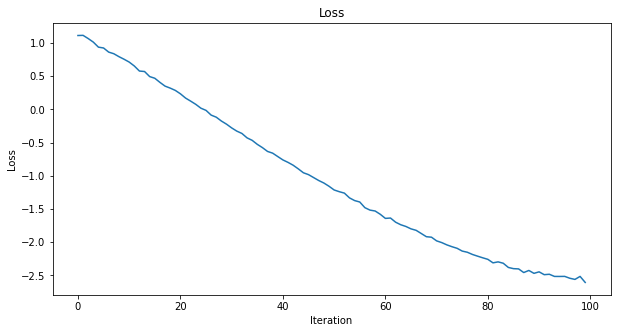

In [2]:
model, x_test = default_train()

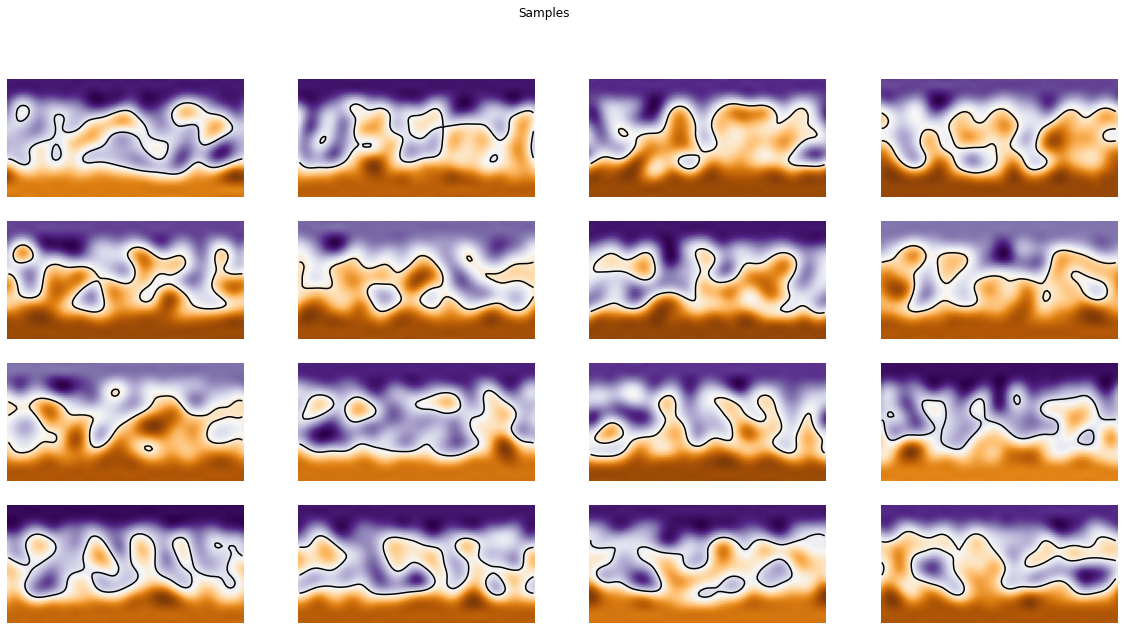

In [17]:
samples = model.predict(x_test.to(device), num_samples=100, need_plot=True)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()

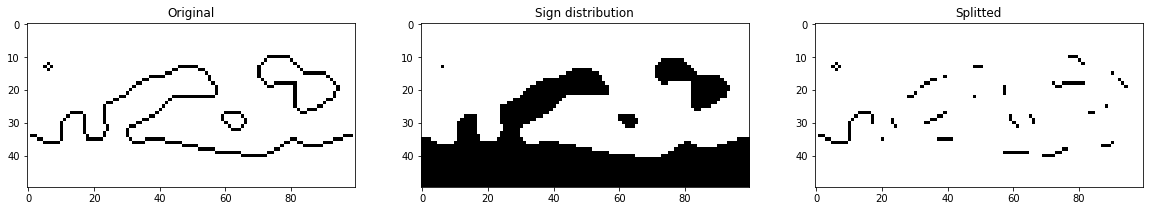

In [18]:
original, sign, splitted = prepare_gpr_results(samples[0], x_parts=5, scale_coef=0.85, color=0, need_plot=True)

# Experiment

## Training loop

In [ ]:
os.makedirs(PATH_TO_TEST_RESULTS, exist_ok=True)
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'w') as f:
    for i, sample in enumerate(tqdm(samples)):
        cur_dir = os.path.join(PATH_TO_TEST_RESULTS, str(i + 1))
        os.mkdir(cur_dir)
        original, sign, splitted = prepare_gpr_results(sample, x_parts=5, scale_coef=0.85, color=0, need_plot=False)
        f.write(f'sample {i+1}:\n')
        steps = [10, 5, 3, 1]
        map_cascade = [downscale_map(img=splitted, sq_size=step) for step in steps]
        for k in range(4):
            epoch = [2e+4, 2e+4, 15e+3, 1e+4][k]
            for j, cas_map in enumerate(map_cascade):
                dataset = MyData(path_or_img=cas_map, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
                dataset_list = [dataset]
                model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
                model.to(device)
                if j:
                    model.load_state_dict(torch.load(os.path.join(cur_dir, f'cascade_{k}{j}.pt')))
                model.start_training(num_epochs=epoch, my_weight=0.1, need_save=False, need_plot=False)
                torch.save(model.state_dict(), os.path.join(cur_dir, f'cascade_{k}{j+1}.pt'))
            predictions = model.test_model(need_plot=False)
            prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
            a = (prediction > 0).float()
            mae = float(((sign.float() - a).abs()).mean())
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(sign, cmap='PuOr')
            plt.title('Original')
            plt.subplot(1, 3, 2)
            plt.imshow(splitted, cmap='gray')
            plt.title('Splitted')
            plt.subplot(1, 3, 3)
            plt.imshow(prediction > 0, cmap='PuOr')
            plt.title('Prediction {}\nMAE: {:.2f}'.format(k + 1, mae))
            plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
            plt.close()
            plt.clf()
            f.write(f'MAE_{k + 1}: {mae:.2f}\n')
        f.write('\n')

## Metrics analysis

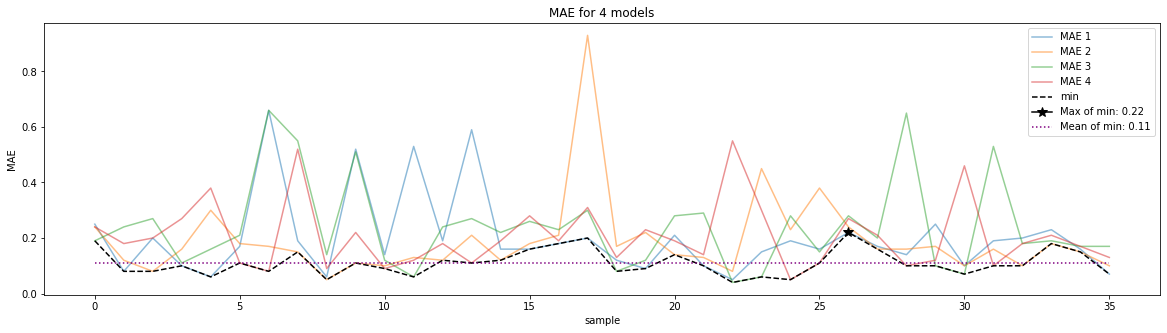

In [29]:
res = []
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'r') as f:
    for line in f:
        if line.startswith('sample'):
            res.append([])
        if line.startswith('MAE'):
            res[-1].append(float(line.split(': ')[1]))
res = np.array(res)
res_min = res.min(axis=1)

# plot res as 4 lines in one plot
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.plot(res[:, i], label=f'MAE {i + 1}', alpha=0.5)
plt.xlabel('sample')
plt.ylabel('MAE')
plt.plot(res_min, label='min', color='black', linestyle='--')
# plot maximun of res_min with star and label
plt.plot(res_min.argmax(), res_min.max(), marker='*', markersize=10, label=f'Max of min: {res_min.max():.2f}', color='black')
# plot mean line of res_min
plt.plot([0, 35], [res_min.mean(), res_min.mean()], label=f'Mean of min: {res_min.mean():.2f}', color='purple', linestyle='dotted')
plt.title('MAE for 4 models')
plt.legend()

In [ ]:
os.makedirs(PATH_TO_TEST_RESULTS, exist_ok=True)
with open(os.path.join(PATH_TO_TEST_RESULTS, 'res.txt'), 'w') as f:
    for i, sample in enumerate(tqdm(samples)):
        cur_dir = os.path.join(PATH_TO_TEST_RESULTS, str(i + 1))
        os.mkdir(cur_dir)
        original, sign, splitted = prepare_gpr_results(sample, x_parts=5, scale_coef=0.85, color=0, need_plot=False)
        f.write(f'sample {i+1}:\n')
        steps = [10, 5, 3, 1]
        map_cascade = [downscale_map(img=splitted, sq_size=step) for step in steps]
        for k in range(4):
            epoch = [2e+4, 2e+4, 15e+3, 1e+4][k]
            for j, cas_map in enumerate(map_cascade):
                dataset = MyData(path_or_img=cas_map, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
                dataset_list = [dataset]
                model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
                model.to(device)
                if j:
                    model.load_state_dict(torch.load(os.path.join(cur_dir, f'cascade_{k}{j}.pt')))
                model.start_training(num_epochs=epoch, my_weight=0.1, need_save=False, need_plot=False)
                torch.save(model.state_dict(), os.path.join(cur_dir, f'cascade_{k}{j+1}.pt'))
            predictions = model.test_model(need_plot=False)
            prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
            a = (prediction > 0).float()
            mae = float(((sign.float() - a).abs()).mean())
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(sign, cmap='PuOr')
            plt.title('Original')
            plt.subplot(1, 3, 2)
            plt.imshow(splitted, cmap='gray')
            plt.title('Splitted')
            plt.subplot(1, 3, 3)
            plt.imshow(prediction > 0, cmap='PuOr')
            plt.title('Prediction {}\nMAE: {:.2f}'.format(k + 1, mae))
            plt.savefig(os.path.join(cur_dir, f'result_{k + 1}.png'), facecolor='white')
            plt.close()
            plt.clf()
            f.write(f'MAE_{k + 1}: {mae:.2f}\n')
        f.write('\n')
        